# Consulting Project: QuickBite Delivery Optimization

Management Science - Food Delivery Logistics

# Client Briefing: QuickBite

## Meet Your Client

-   **Industry:** Food Delivery / Logistics
-   **Client Contact:** Eliza Chen, CEO
-   **Company Size:** 12 employees, 120+ daily deliveries

## The CEO’s Dilemma

**Eliza Chen, CEO of QuickBite**

*“We started QuickBite four years ago with a simple mission: deliver
restaurant-quality meals to busy citizens in Hamburg. But we’re bleeding
money on delivery costs while customers complain about cold food!*

*Right now, our 4 drivers just… wing it. They look at their delivery
list each morning and decide their own routes based on ‘intuition.’ The
results are terrible:*

-   *75% of deliveries arrive late*
-   *Customer complaints about cold food: Up 40% this quarter*

*Our investors are getting nervous. We need to cut delivery costs AND
improve on-time delivery. Can you help us design optimal routes that
keep food hot and costs low?*

*We have data from last week’s operations. Please show us what’s
possible!“*

## The Business Context

### Current Operations

-   **Daily deliveries:** 120 meal orders across Hamburg
-   **Fleet:** 4 delivery drivers with insulated cars
-   **Depot:** Central location (Hamburg Hauptbahnhof area)
-   **Service hours:** 11:00 AM - 9:00 PM
-   **Driver capacity:** Each driver can carry up to 35 meals at once

### Cost Structure

-   **Driver wages:** €18/hour (including benefits)
-   **Fuel costs:** €0.55 per km
-   **Late delivery penalty:** €5 per late delivery (customer discount)
-   **Cold food complaints:** €10 per complaint

### Customer Expectations

-   Each delivery has a **time window** (requested delivery time ± 15
    minutes)
-   **Time window violation = Late penalty + Potential cold food
    complaint**

## Your Mission

Design an optimal routing system for QuickBite’s 4 drivers that:

1.  **Minimizes total delivery costs** (driver time + fuel + penalties)
2.  **Maximizes on-time deliveries** (arrive within time windows)
3.  **Respects vehicle capacity** (max 35 meals per driver at once)
4.  **Ensures fairness** (balanced workload across drivers)

## The Data

Below is real data from last Tuesday, a typical operating day for
QuickBite.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(2025)

# Depot location (Hamburg Hauptbahnhof)
depot = {
    'name': 'QuickBite Depot',
    'lat': 53.5511,
    'lon': 10.0063
}

# Generate 120 delivery locations across Hamburg
# Hamburg spans roughly: lat 53.45-53.65, lon 9.85-10.15
def generate_hamburg_deliveries(n=120):
    deliveries = []

    # Create realistic clusters (residential areas, business districts)
    clusters = [
        {'lat': 53.5511, 'lon': 10.0063, 'n': 30, 'type': 'city_center'},      # Altstadt
        {'lat': 53.5534, 'lon': 9.9700, 'n': 25, 'type': 'residential'},       # Altona
        {'lat': 53.5753, 'lon': 10.0153, 'n': 18, 'type': 'residential'},      # Eppendorf
        {'lat': 53.5580, 'lon': 10.0742, 'n': 20, 'type': 'business'},         # Wandsbek
        {'lat': 53.5252, 'lon': 9.9350, 'n': 12, 'type': 'residential'},       # Bahrenfeld
        {'lat': 53.5440, 'lon': 10.0465, 'n': 15, 'type': 'business'},         # HafenCity
    ]

    delivery_id = 1
    for cluster in clusters:
        for i in range(cluster['n']):
            # Add random variation around cluster center
            lat = np.random.normal(cluster['lat'], 0.008)
            lon = np.random.normal(cluster['lon'], 0.012)

            # Determine time window based on cluster type
            if cluster['type'] == 'business':
                # Business districts: More lunch orders
                hour = np.random.choice([12, 13, 18, 19], p=[0.4, 0.3, 0.2, 0.1])
            else:
                # Residential: More dinner orders
                hour = np.random.choice([12, 13, 18, 19], p=[0.1, 0.2, 0.4, 0.3])

            minute = np.random.randint(0, 60)

            # Time window: ±15 minutes from requested time
            requested_time = f"{hour:02d}:{minute:02d}"
            window_start = f"{hour:02d}:{max(0, minute-15):02d}"
            window_end_min = minute + 15
            window_end_hour = hour + (window_end_min // 60)
            window_end_min = window_end_min % 60
            window_end = f"{window_end_hour:02d}:{window_end_min:02d}"

            deliveries.append({
                'delivery_id': delivery_id,
                'lat': lat,
                'lon': lon,
                'area': cluster['type'],
                'requested_time': requested_time,
                'window_start': window_start,
                'window_end': window_end,
                'order_value': np.random.normal(35, 10)
            })
            delivery_id += 1

    return pd.DataFrame(deliveries)

# Generate delivery data
deliveries_df = generate_hamburg_deliveries(120)

# Display first 10 deliveries
print("QUICKBITE DELIVERY DATA - Tuesday, Nov 19, 2024")
print("=" * 80)
print(deliveries_df.head(10).to_string(index=False))
print(f"\n... and {len(deliveries_df) - 10} more deliveries")
print("\n" + "=" * 80)
print(f"Total deliveries: {len(deliveries_df)}")
print(f"Total order value: €{deliveries_df['order_value'].sum():.2f}")

QUICKBITE DELIVERY DATA - Tuesday, Nov 19, 2024
 delivery_id       lat       lon        area requested_time window_start window_end  order_value
           1 53.550361 10.015111 city_center          18:22        18:07      18:37    44.387576
           2 53.545443  9.993619 city_center          18:03        18:00      18:18    31.338218
           3 53.557661  9.987915 city_center          19:09        19:00      19:24    42.862084
           4 53.539506  9.973181 city_center          18:31        18:16      18:46    36.461754
           5 53.559608 10.006745 city_center          12:45        12:30      13:00    34.959365
           6 53.559704  9.997752 city_center          19:36        19:21      19:51    39.476978
           7 53.545861  9.998407 city_center          19:04        19:00      19:19    29.864538
           8 53.549267  9.986467 city_center          18:25        18:10      18:40    31.091045
           9 53.552830 10.005464 city_center          19:14        19:00      1

## Delivery Visualization

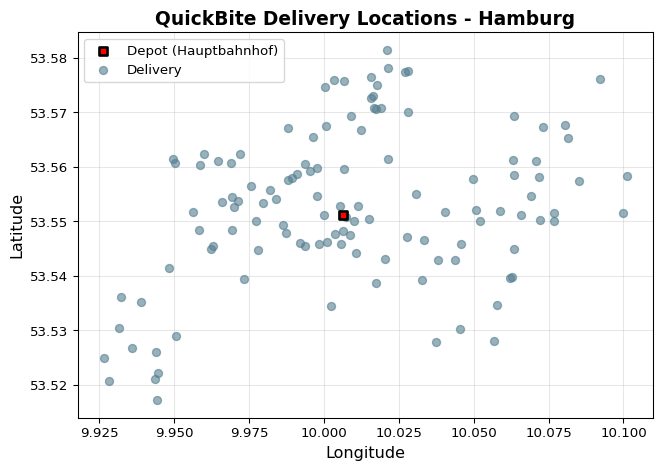

In [2]:
def visualize_deliveries(deliveries_df, depot_location, routes=None):
    """
    Visualize all delivery locations and optional routes.

    Args:
        deliveries_df: DataFrame with delivery information
        depot_location: Dict with 'lat' and 'lon' keys
        routes: Optional list of routes, where each route is a list of delivery_ids
    """
    plt.figure()

    # Plot depot
    plt.scatter(depot_location['lon'], depot_location['lat'],
                c='red', marker='s', zorder=5,
                label='Depot (Hauptbahnhof)', edgecolors='black', linewidths=2)

    # Plot all deliveries
    plt.scatter(deliveries_df['lon'], deliveries_df['lat'],
                c='#537E8F', alpha=0.6, label='Delivery', zorder=3)

    # If routes are provided, draw them
    if routes is not None:
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        for i, route in enumerate(routes):
            if len(route) == 0:
                continue

            # Start from depot
            route_lons = [depot_location['lon']]
            route_lats = [depot_location['lat']]

            # Add delivery points
            for delivery_id in route:
                delivery = deliveries_df[deliveries_df['delivery_id'] == delivery_id].iloc[0]
                route_lons.append(delivery['lon'])
                route_lats.append(delivery['lat'])

            # Return to depot
            route_lons.append(depot_location['lon'])
            route_lats.append(depot_location['lat'])

            # Plot route
            plt.plot(route_lons, route_lats,
                    color=colors[i % len(colors)], linewidth=2,
                    alpha=0.7, label=f'Driver {i+1} Route', zorder=2)

    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title('QuickBite Delivery Locations - Hamburg', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize all deliveries
visualize_deliveries(deliveries_df, depot)

## Helper Functions (Minimal Code Provided)

I provide only basic helper functions. **You must implement the routing
algorithms yourself.**

In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate distance between two GPS coordinates using Haversine formula.
    Returns distance in kilometers.
    """
    from math import radians, sin, cos, sqrt, atan2

    R = 6371  # Earth's radius in kilometers

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    return R * c

def create_distance_matrix(deliveries_df, depot_location):
    """
    Create distance matrix for all locations (depot + all deliveries).
    Returns numpy array where index 0 is depot, indices 1-120 are deliveries.
    """
    n = len(deliveries_df) + 1  # +1 for depot
    distances = np.zeros((n, n))

    # Depot distances
    for i, row in deliveries_df.iterrows():
        dist = haversine_distance(depot_location['lat'], depot_location['lon'],
                                  row['lat'], row['lon'])
        distances[0, i+1] = dist
        distances[i+1, 0] = dist

    # Delivery-to-delivery distances
    for i, row1 in deliveries_df.iterrows():
        for j, row2 in deliveries_df.iterrows():
            if i != j:
                dist = haversine_distance(row1['lat'], row1['lon'],
                                        row2['lat'], row2['lon'])
                distances[i+1, j+1] = dist

    return distances

# Create distance matrix
distance_matrix = create_distance_matrix(deliveries_df, depot)
print(f"\nDistance matrix created: {distance_matrix.shape}")
print(f"Example: Depot to Delivery #1 = {distance_matrix[0, 1]:.2f} km")


Distance matrix created: (121, 121)
Example: Depot to Delivery #1 = 0.59 km

## Cost Calculation Function

In [4]:
def calculate_route_cost(route, deliveries_df, distance_matrix, depot_location):
    """
    Calculate total cost for a single route.

    Args:
        route: List of delivery_ids in visit order
        deliveries_df: DataFrame with delivery information
        distance_matrix: Numpy array of distances
        depot_location: Dict with depot location

    Returns:
        dict with cost breakdown
    """
    if len(route) == 0:
        return {'total_cost': 0, 'distance': 0, 'time': 0, 'late_penalties': 0}

    # Constants
    DRIVER_WAGE = 18  # €/hour
    FUEL_COST = 0.55  # €/km
    LATE_PENALTY = 5  # €/delivery
    COLD_FOOD_COST = 10  # €/delivery (if late > 60 minutes)
    AVG_SPEED = 25    # km/h (Hamburg traffic)
    SERVICE_TIME = 3  # minutes per delivery

    total_distance = 0
    total_time = 0  # minutes
    late_count = 0
    cold_food_count = 0
    current_time = datetime.strptime("11:00", "%H:%M")  # Start time

    # Depot to first delivery
    first_delivery_id = route[0]
    first_idx = deliveries_df[deliveries_df['delivery_id'] == first_delivery_id].index[0]
    total_distance += distance_matrix[0, first_idx + 1]
    travel_time = (distance_matrix[0, first_idx + 1] / AVG_SPEED) * 60  # minutes
    current_time += timedelta(minutes=travel_time)

    # Check delivery time window
    delivery_info = deliveries_df.iloc[first_idx]
    window_start = datetime.strptime(delivery_info['window_start'], "%H:%M")
    window_end = datetime.strptime(delivery_info['window_end'], "%H:%M")

    # If arrived early, wait until window opens
    if current_time.time() < window_start.time():
        wait_time = (window_start.hour * 60 + window_start.minute) - (current_time.hour * 60 + current_time.minute)
        total_time += wait_time
        current_time = window_start

    # Check if late
    if current_time.time() > window_end.time():
        late_count += 1
        # Check if late by more than 60 minutes (cold food complaint)
        late_minutes = (current_time.hour * 60 + current_time.minute) - (window_end.hour * 60 + window_end.minute)
        if late_minutes > 60:
            cold_food_count += 1

    current_time += timedelta(minutes=SERVICE_TIME)
    total_time += SERVICE_TIME

    # Delivery to delivery
    for i in range(len(route) - 1):
        from_id = route[i]
        to_id = route[i + 1]

        from_idx = deliveries_df[deliveries_df['delivery_id'] == from_id].index[0]
        to_idx = deliveries_df[deliveries_df['delivery_id'] == to_id].index[0]

        dist = distance_matrix[from_idx + 1, to_idx + 1]
        total_distance += dist

        travel_time = (dist / AVG_SPEED) * 60
        current_time += timedelta(minutes=travel_time)

        # Check delivery time window
        delivery_info = deliveries_df.iloc[to_idx]
        window_start = datetime.strptime(delivery_info['window_start'], "%H:%M")
        window_end = datetime.strptime(delivery_info['window_end'], "%H:%M")

        # If arrived early, wait until window opens
        if current_time.time() < window_start.time():
            wait_time = (window_start.hour * 60 + window_start.minute) - (current_time.hour * 60 + current_time.minute)
            total_time += wait_time
            current_time = window_start

        # Check if late
        if current_time.time() > window_end.time():
            late_count += 1
            # Check if late by more than 60 minutes (cold food complaint)
            late_minutes = (current_time.hour * 60 + current_time.minute) - (window_end.hour * 60 + window_end.minute)
            if late_minutes > 60:
                cold_food_count += 1

        current_time += timedelta(minutes=SERVICE_TIME)
        total_time += SERVICE_TIME

    # Return to depot
    last_delivery_id = route[-1]
    last_idx = deliveries_df[deliveries_df['delivery_id'] == last_delivery_id].index[0]
    total_distance += distance_matrix[last_idx + 1, 0]
    travel_time = (distance_matrix[last_idx + 1, 0] / AVG_SPEED) * 60
    total_time += travel_time

    # Calculate costs
    driver_cost = DRIVER_WAGE * (total_time / 60)  # Convert minutes to hours
    fuel_cost = FUEL_COST * total_distance
    penalty_cost = LATE_PENALTY * late_count
    cold_food_cost = COLD_FOOD_COST * cold_food_count

    return {
        'total_cost': driver_cost + fuel_cost + penalty_cost + cold_food_cost,
        'driver_cost': driver_cost,
        'fuel_cost': fuel_cost,
        'penalty_cost': penalty_cost,
        'cold_food_cost': cold_food_cost,
        'distance': total_distance,
        'time': total_time,
        'late_count': late_count,
        'cold_food_count': cold_food_count,
        'on_time_rate': 1 - (late_count / len(route)) if len(route) > 0 else 1.0
    }

# Example: Calculate cost for a simple route
example_route = [1, 2, 3, 4, 5]
example_cost = calculate_route_cost(example_route, deliveries_df, distance_matrix, depot)
print("\nExample route cost breakdown:")
for key, value in example_cost.items():
    print(f"  {key}: {value:.2f}")


Example route cost breakdown:
  total_cost: 170.40
  driver_cost: 144.98
  fuel_cost: 5.42
  penalty_cost: 10.00
  cold_food_cost: 10.00
  distance: 9.86
  time: 483.27
  late_count: 2.00
  cold_food_count: 1.00
  on_time_rate: 0.60

## Your Task

You must develop a routing solution that assigns all 120 deliveries to 4
drivers and provides:

### 1. Jupyter Notebook with Complete Solution

Your notebook should include:

-   **Data exploration:** Visualizations and insights about delivery
    patterns
-   **Algorithm implementation:** Your routing approach (construction +
    improvement)
-   **Results:** Final routes for all 4 drivers with cost breakdown
-   **Analysis:** Comparison to a baseline (e.g. random assignment)

> **Note**
>
> I won’t judge the code quality in this notebook. It’s just for me to
> review your final solution and identify any mistakes if your results
> seem unrealistic. The final project will be graded primarily based on
> your presentation and the results you have achieved.

### 2. Presentation

-   **Problem understanding:** Eliza’s pain points in your own words
-   **Your approach:** Algorithm choice and justification
-   **Results:** Routes visualization, cost savings, on-time improvement
-   **Business impact:** Recommendations for QuickBite

> **Note**
>
> Please upload both, presentation and jupyter notebook (or `.py` files)
> for the final project.

### 3. Key Metrics to Report

-   Total cost (all 4 drivers combined)
-   Total distance traveled
-   On-time delivery rate (% within time windows)
-   Number of late deliveries
-   Driver workload balance (fairness)
-   **Cost savings vs. current system** (estimate baseline first!)

## Constraints and Requirements

> **Important**
>
> **Hard Constraints (Must Satisfy)**
>
> 1.  **All deliveries assigned:** Every delivery must be assigned to
>     exactly one driver
> 2.  **Vehicle capacity:** Each driver can carry max 35 meals at once
> 3.  **Start and end at depot:** All routes begin and end at the depot
> 4.  **Time feasibility:** Deliveries should be attempted within
>     operating hours (11:00-21:00)
>
> **Soft Constraints (Optimize)**
>
> 1.  **Minimize total cost** (driver time + fuel + late penalties +
>     cold food costs)
> 2.  **Maximize on-time delivery rate**
> 3.  **Balance workload** across drivers (fairness)

## Tips for Success

1.  **Capacity matters:** With 120 deliveries and 35-meal capacity, you
    will need to use all drivers. This affects your algorithm design!
2.  **Time windows are critical:** Late penalties and cold food
    complaints are expensive. Sometimes driving extra distance to be on
    time is worth it.
3.  **Clustering helps:** Hamburg has natural neighborhood clusters. Use
    them!
4.  **Visualize early:** Plot routes as you develop them. Bad routes are
    obvious visually.
5.  **Start simple:** Get a working solution first, then optimize.
6.  **Fairness counts:** Drivers will quit if workload is unfair.
    Balance is important. :::

## Common Pitfalls to Avoid

-   **Ignoring capacity:** Don’t create routes with 40 deliveries for
    one driver!
-   **Forgetting to return to depot:** Routes must be round-trips
-   **Not checking time windows:** Validate after every algorithmic
    change
-   **Over-optimization:** A good solution with clear explanation beats
    a “perfect” black box
-   **Poor visualization:** Make sure your routes are clearly visible
    and understandable
-   **No baseline comparison:** Always show improvement vs. current
    system!

## Data Access

All data is provided in this notebook:

-   `deliveries_df`: DataFrame with 120 deliveries
-   `depot`: Dict with depot location
-   `distance_matrix`: Numpy array of distances
-   Helper functions: `calculate_route_cost()`, `visualize_deliveries()`

**You may add additional functions as needed!**

## Deadline

-   **Notebook submission & Presentation:** Lecture 12
-   **Good luck, consultants!**